In [62]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
import clip
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [63]:
torch.cuda.is_available()

True

In [64]:
data = pd.read_csv('cat_dog1.csv')
data

,Unnamed: 0,image,labels
0,0,dog.624.jpg,1
1,1,cat.170.jpg,0
2,2,dog.419.jpg,1
3,3,dog.19.jpg,1
4,4,cat.227.jpg,0
...,...,...,...
1995,1995,dog.481.jpg,1
1996,1996,dog.159.jpg,1
1997,1997,cat.576.jpg,0
1998,1998,dog.190.jpg,1


In [65]:
#a-Spliting the dataset into training and testing sets with 20% for test dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [66]:
train_data.sort_values(train_data.columns[2], axis = 0, inplace=True) #sort by label
train_cats = train_data[train_data['labels'] == 0]
train_dogs = train_data[train_data['labels'] == 1]


In [67]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"

model, transform = clip.load("ViT-B/32", device) 

In [68]:
preproc_img_train_cat = []
preproc_img_train_dog = []
preproc_img_test = []

In [69]:
for file in train_cats['image']:
  preproc_img_train_cat.append(transform(Image.open('cat_dog1/' + file )).unsqueeze(0).to(device))
for file in train_dogs['image']:
  preproc_img_train_dog.append(transform(Image.open('cat_dog1/' + file )).unsqueeze(0).to(device))

for file in test_data['image']:
  preproc_img_test.append(transform(Image.open('cat_dog1/' + file)).unsqueeze(0).to(device))

In [70]:
#encode the inputs
image_embeddings_train_dog = []
image_embeddings_train_cat = []
image_embeddings_test = []
torch.cuda.empty_cache()
with torch.no_grad():
  for image in preproc_img_train_cat:
    image_embeddings_train_cat.append((model.encode_image(image)).cpu().detach().numpy())
  
  for image in preproc_img_train_dog:
    image_embeddings_train_dog.append((model.encode_image(image)).cpu().detach().numpy())

  for image in preproc_img_test:
    image_embeddings_test.append((model.encode_image(image)).cpu().detach().numpy())


In [71]:
image_embeddings_train_cat = np.vstack(image_embeddings_train_cat)
image_embeddings_train_dog = np.vstack(image_embeddings_train_dog)
image_embeddings_test = np.vstack(image_embeddings_test)


In [72]:
#Fisher's Algorithm
c = 0.1
means = []
means.append(image_embeddings_train_cat.mean(axis = 0))
means.append(image_embeddings_train_dog.mean(axis = 0))
S =  np.cov(image_embeddings_train_cat, rowvar=False) + np.cov(image_embeddings_train_dog, rowvar=False)
S_inv = np.linalg.inv(S)
mean_dif = means[1] - means[0]
w = c*np.dot(S_inv, mean_dif)

In [73]:
#predictions with c = 0.1
predict_c1 = np.dot(image_embeddings_test, w.T)

Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


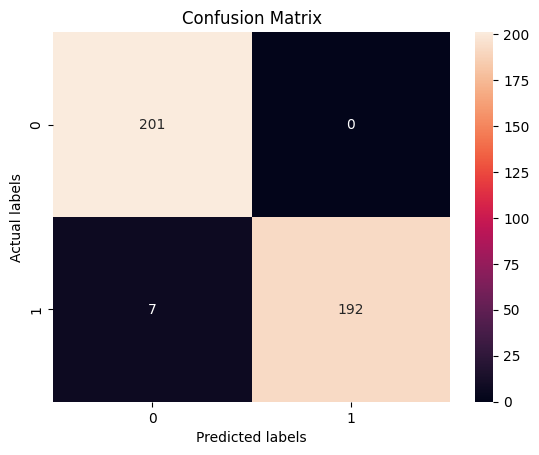

In [74]:
#Scores
#Convert prediction scores into binary class predictions using a 0.0 threshold
predicted_labels_c1 = (predict_c1 > 0.0).astype(int)

#Calculations of metrics
accuracy = accuracy_score(test_data['labels'], predicted_labels_c1)
precision = precision_score(test_data['labels'], predicted_labels_c1)
recall = recall_score(test_data['labels'], predicted_labels_c1)
f1 = f1_score(test_data['labels'], predicted_labels_c1)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

#Generating Confusion Matrix
confusion_matrix_c1 = confusion_matrix(test_data['labels'], predicted_labels_c1)
sns.heatmap(confusion_matrix_c1, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [75]:
#Bonus

C = [0.2, 0.3, 0.4, 0.5, 0.7]
W = []
for c in C:
  W.append(c*np.dot(S_inv, mean_dif))



In [76]:
predict_C = []
for w in W:
  predict_C.append(np.dot(image_embeddings_test, w.T))

Metrics for c= 0.2:
Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


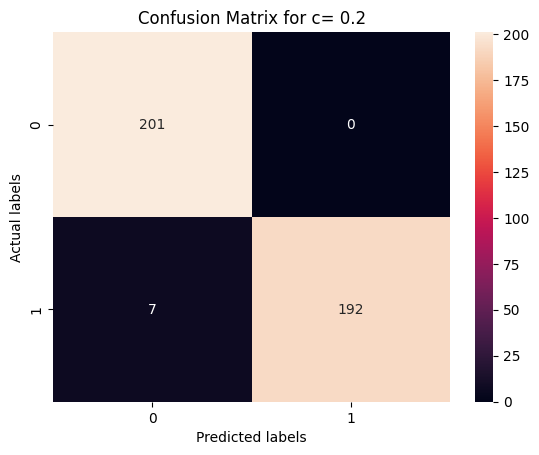

Metrics for c= 0.3:
Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


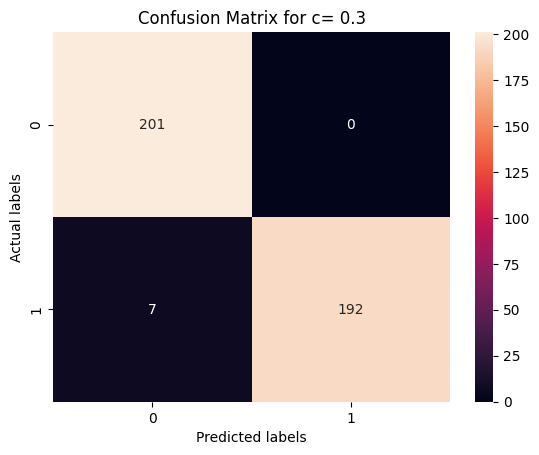

Metrics for c= 0.4:
Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


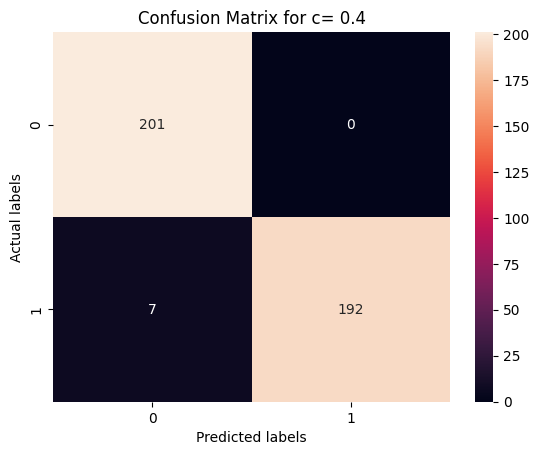

Metrics for c= 0.5:
Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


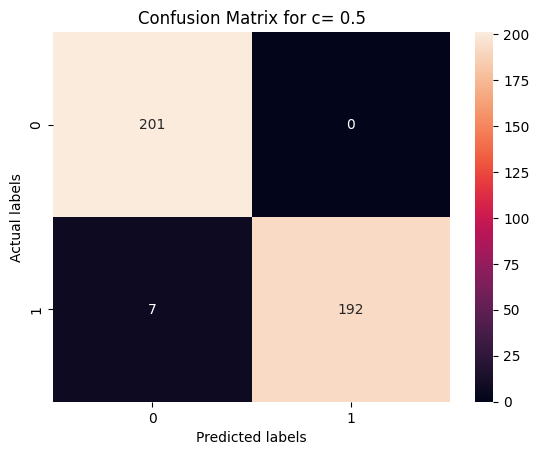

Metrics for c= 0.7:
Accuracy: 0.9825
Precision: 1.0
Recall: 0.964824120603015
F1 Score: 0.9820971867007673


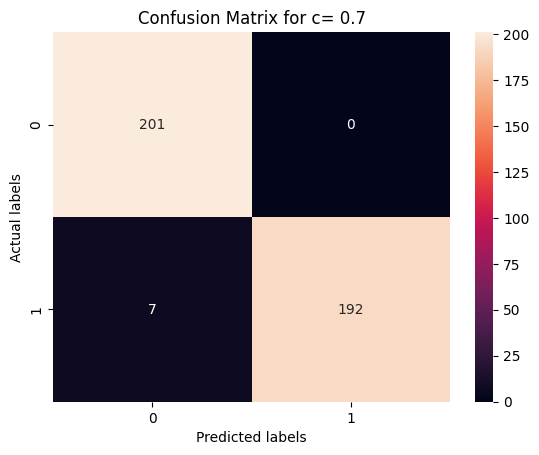

In [77]:
#Scores
#C = 0.2
predicted_labels_C1 = (predict_C[0] > 0.0).astype(int)
    
#Calculations of metrics
accuracy_C1 = accuracy_score(test_data['labels'], predicted_labels_C1)
precision_C1 = precision_score(test_data['labels'], predicted_labels_C1)
recall_C1 = recall_score(test_data['labels'], predicted_labels_C1)
f1_C1 = f1_score(test_data['labels'], predicted_labels_C1)
    
print('Metrics for c= 0.2:')
print('Accuracy:', accuracy_C1)
print('Precision:', precision_C1)
print('Recall:', recall_C1)
print('F1 Score:', f1_C1)
    
#Generating Confusion Matrix
confusion_matrix_C1 = confusion_matrix(test_data['labels'], predicted_labels_C1)
sns.heatmap(confusion_matrix_C1, annot=True, fmt='d')
plt.title('Confusion Matrix for c= 0.2')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

#C = 0.3
predicted_labels_C2 = (predict_C[1] > 0.0).astype(int)

#Calculations of metrics
accuracy_C2 = accuracy_score(test_data['labels'], predicted_labels_C2)
precision_C2 = precision_score(test_data['labels'], predicted_labels_C2)
recall_C2 = recall_score(test_data['labels'], predicted_labels_C2)
f1_C2 = f1_score(test_data['labels'], predicted_labels_C2)
    
print('Metrics for c= 0.3:')
print('Accuracy:', accuracy_C2)
print('Precision:', precision_C2)
print('Recall:', recall_C2)
print('F1 Score:', f1_C2)

#Generating Confusion Matrix
confusion_matrix_C2 = confusion_matrix(test_data['labels'], predicted_labels_C2)
sns.heatmap(confusion_matrix_C2, annot=True, fmt='d')
plt.title('Confusion Matrix for c= 0.3')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

#C = 0.4
predicted_labels_C3 = (predict_C[2] > 0.0).astype(int)
    
#Calculations of metrics
accuracy_C3 = accuracy_score(test_data['labels'], predicted_labels_C3)
precision_C3 = precision_score(test_data['labels'], predicted_labels_C3)
recall_C3 = recall_score(test_data['labels'], predicted_labels_C3)
f1_C3 = f1_score(test_data['labels'], predicted_labels_C3)
    
print('Metrics for c= 0.4:')
print('Accuracy:', accuracy_C3)
print('Precision:', precision_C3)
print('Recall:', recall_C3)
print('F1 Score:', f1_C3)
    
#Generating Confusion Matrix
confusion_matrix_C3 = confusion_matrix(test_data['labels'], predicted_labels_C3)
sns.heatmap(confusion_matrix_C3, annot=True, fmt='d')
plt.title('Confusion Matrix for c= 0.4')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

#C = 0.5
predicted_labels_C4 = (predict_C[3] > 0.0).astype(int)
    
#Calculations of metrics
accuracy_C4 = accuracy_score(test_data['labels'], predicted_labels_C4)
precision_C4 = precision_score(test_data['labels'], predicted_labels_C4)
recall_C4 = recall_score(test_data['labels'], predicted_labels_C4)
f1_C4 = f1_score(test_data['labels'], predicted_labels_C4)
    
print('Metrics for c= 0.5:')
print('Accuracy:', accuracy_C4)
print('Precision:', precision_C4)
print('Recall:', recall_C4)
print('F1 Score:', f1_C4)
    
#Generating Confusion Matrix
confusion_matrix_C4 = confusion_matrix(test_data['labels'], predicted_labels_C4)
sns.heatmap(confusion_matrix_C4, annot=True, fmt='d')
plt.title('Confusion Matrix for c= 0.5')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

#C = 0.7
predicted_labels_C5 = (predict_C[4] > 0.0).astype(int)
    
#Calculations of metrics
accuracy_C5 = accuracy_score(test_data['labels'], predicted_labels_C5)
precision_C5 = precision_score(test_data['labels'], predicted_labels_C5)
recall_C5 = recall_score(test_data['labels'], predicted_labels_C5)
f1_C5 = f1_score(test_data['labels'], predicted_labels_C5)
    
print('Metrics for c= 0.7:')
print('Accuracy:', accuracy_C5)
print('Precision:', precision_C5)
print('Recall:', recall_C5)
print('F1 Score:', f1_C5)
    
#Generating Confusion Matrix
confusion_matrix_C5 = confusion_matrix(test_data['labels'], predicted_labels_C5)
sns.heatmap(confusion_matrix_C5, annot=True, fmt='d')
plt.title('Confusion Matrix for c= 0.7')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()
